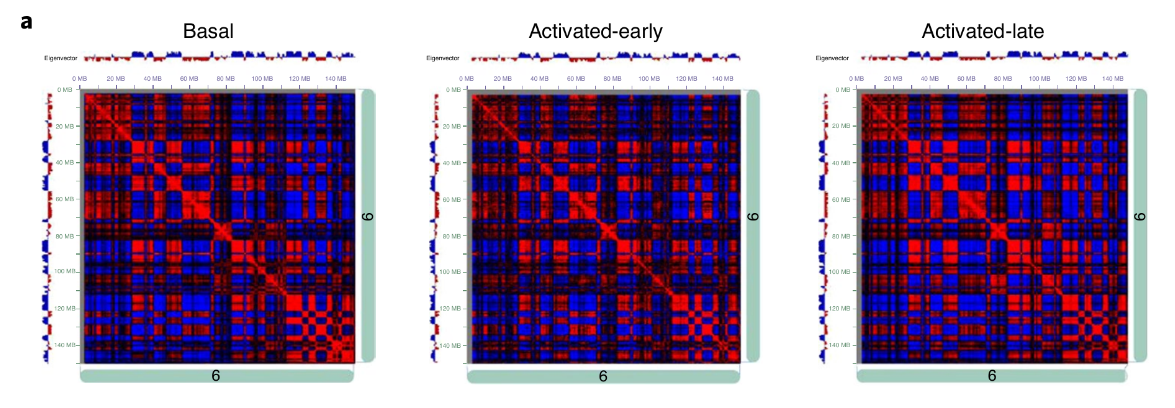

## Setup environmnet 

In [4]:
%load_ext rpy2.ipython 

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


-----------------------------------------------------------------------------------------------------
- [ ] install bowtie2 from source: 
    ```https://www.metagenomics.wiki/tools/bowtie2/install```

- [ ] install HiC-Pro from source
    ```
    wget github zip
    tar -zxvf HiC-Pro-3.1.0.tar.gz
    cd HiC-Pro-3.1.0
    make configure
    make install
    ``` 
- [ ] install zlib from source (conda)
- [ ] install SRA tools
    ```install sra toolkit form source --> https://github.com/ncbi/sra-tools/wiki/02.-Installing-SRA-Toolkit```
- [ ] install Hi-Pro
    ```download HiC-Pro from github repo
    tar -zxvf HiC-Pro-3.1.0.tar.gz
    cd HiC-Pro-3.1.0```
-----------------------------------------------------------------------------------------------------

In [36]:
!pip install multiqc

     |████████████████████████████████| 1.2 MB 6.2 MB/s eta 0:00:01
     |████████████████████████████████| 46 kB 1.4 MB/s  eta 0:00:01
     |████████████████████████████████| 130 kB 51.1 MB/s eta 0:00:01
     |████████████████████████████████| 829 kB 68.6 MB/s eta 0:00:01
     |████████████████████████████████| 86 kB 2.1 MB/s  eta 0:00:01
  Created wheel for lzstring: filename=lzstring-1.0.4-py2.py3-none-any.whl size=4574 sha256=d0f48e328954f654dafc38c5a2f9fa4c2086a89e952b97fd1c37bfc9068c6e09
  Stored in directory: /home/mila/i/ionelia.buzatu/.cache/pip/wheels/f1/e0/9f/2d1e57842b9e3a9f030519f6ea5e55a21ba7d4f5bcbb4ef578
  Created wheel for spectra: filename=spectra-0.0.11-py3-none-any.whl size=17472 sha256=ba06da73cce524567d457c84f35073d76d6dc26de902990579052ecad3bd4613
  Stored in directory: /home/mila/i/ionelia.buzatu/.cache/pip/wheels/e3/c8/a4/5a566fafff827fcb5741589e42002686bb29990fbc7b262b5e
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491059 sha256=100

## Download data

Analysing samples from GEO: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE152953

| name | SRA id | 
|:---:|:---:|
| Basal_rep1| [SRR12066882](https://trace.ncbi.nlm.nih.gov/Traces/index.html?view=run_browser&acc=SRR12066882&display=metadata) |
| Basal_rep2 |[SRR12066883](https://trace.ncbi.nlm.nih.gov/Traces/index.html?view=run_browser&acc=SRR12066883&display=metadata) |
| Early_rep1 | [SRR12066884](https://trace.ncbi.nlm.nih.gov/Traces/index.html?view=run_browser&acc=SRR12066884&display=metadata) |
| Late_rep1 | [SRR12066885](https://trace.ncbi.nlm.nih.gov/Traces/index.html?view=run_browser&acc=SRR12066885&display=metadata)|
| Late_rep2 | [SRR12066886](https://trace.ncbi.nlm.nih.gov/Traces/index.html?view=run_browser&acc=SRR12066886&display=metadata) |




In [ ]:
%%bash
data_folder="/network/projects/_groups/grn_control/bow/3d-pipeline/data"
cd $data_folder
pwd
for i in SRR12066883,basal_rep2 SRR12066884,early_rep1 SRR12066885,late_rep1 SRR12066886,late_rep2; do
    IFS=","; set -- $i;
    sra=$1
    id_name=$2
    echo "downloading..."$sra;
    prefetch $sra
    echo "splitting paired reads..."
    fastq-dump --split-3 $sra --outdir $sra/
    mv $sra"/"$sra"_1.fastq" $sra"/"$id_name"_R1.fastq"
    mv $sra/$sra"_2.fastq" $sra/$id_name"_R2.fastq"
done

In [47]:
HiCPro="/network/projects/_groups/grn_control/bow/programs/HicProinstalldir/HiC-Pro_3.1.0/bin/HiC-Pro"

In [48]:
!$HiCPro

usage : HiC-Pro -i INPUT -o OUTPUT -c CONFIG [-s ANALYSIS_STEP] [-p] [-h] [-v]
Use option -h|--help for more information


## Genome index

In [37]:
# getting mm9 bowtie2 indexor built it
!cd $bowtie2_all_indexes && wget https://genome-idx.s3.amazonaws.com/bt/mm9.zip 

--2022-11-22 13:30:09--  https://genome-idx.s3.amazonaws.com/bt/mm9.zip
Resolving genome-idx.s3.amazonaws.com (genome-idx.s3.amazonaws.com)... 52.216.20.8, 52.217.79.124, 52.216.236.139, ...
Connecting to genome-idx.s3.amazonaws.com (genome-idx.s3.amazonaws.com)|52.216.20.8|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3339711395 (3.1G) [application/zip]
Saving to: ‘mm9.zip’

mm9.zip             100%[===================>]   3.11G  26.6MB/s    in 2m 30s  

2022-11-22 13:32:39 (21.2 MB/s) - ‘mm9.zip’ saved [3339711395/3339711395]



In [39]:
!cd $bowtie2_all_indexes && mkdir mm9 && unzip mm9.zip -d mm9

Archive:  mm9.zip
  inflating: mm9/mm9.1.bt2           
  inflating: mm9/mm9.2.bt2           
  inflating: mm9/mm9.3.bt2           
  inflating: mm9/mm9.4.bt2           
  inflating: mm9/mm9.rev.1.bt2       
  inflating: mm9/mm9.rev.2.bt2       
  inflating: mm9/make_mm9.sh         


%%bash
cd $root && wget http://hgdownload.soe.ucsc.edu/goldenPath/mm9/bigZips/mm9.fa.gz && gunzip -f mm9.fa.gz

## Generating the restriction enzyme bed file

In [47]:
#for hindii
!/network/projects/_groups/grn_control/bow/programs/HicProinstalldir/HiC-Pro_3.1.0/bin/utils/digest_genome.py -r A^AGCTT \
    -o /network/projects/_groups/grn_control/bow/mm9_hindiii.bed /network/projects/_groups/grn_control/bow/fasta-genomes/mm9/mm9.fa

Analyzing /network/projects/_groups/grn_control/bow/fasta-genomes/mm9/mm9.fa
Restriction site(s) AAGCTT
Offset(s) 1
chr1...
chr2...
chr3...
chr4...
chr5...
chr6...
chr7...
chr8...
chr9...
chr10...
chr11...
chr12...
chr13...
chr14...
chr15...
chr16...
chr17...
chr18...
chr19...
chrX...
chrY...
chrM...
chr13_random...
chr16_random...
chr17_random...
chr1_random...
chr3_random...
chr4_random...
chr5_random...
chr7_random...
chr8_random...
chr9_random...
chrUn_random...
chrX_random...
chrY_random...
Writing to /network/projects/_groups/grn_control/bow/mm9_hindiii.bed ...


In [9]:
# for dpnii
!!/network/projects/_groups/grn_control/bow/programs/HicProinstalldir/HiC-Pro_3.1.0/bin/utils/digest_genome.py \
    -r dpnii -o /network/projects/_groups/grn_control/bow/mm9_dpnii.bed \
    /network/projects/_groups/grn_control/bow/fasta-files-genomes/mm9/mm9.fa

['Analyzing /network/projects/_groups/grn_control/bow/fasta-files-genomes/mm9/mm9.fa',
 'Restriction site(s) GATC',
 'Offset(s) 0',
 'chr1...',
 'chr2...',
 'chr3...',
 'chr4...',
 'chr5...',
 'chr6...',
 'chr7...',
 'chr8...',
 'chr9...',
 'chr10...',
 'chr11...',
 'chr12...',
 'chr13...',
 'chr14...',
 'chr15...',
 'chr16...',
 'chr17...',
 'chr18...',
 'chr19...',
 'chrX...',
 'chrY...',
 'chrM...',
 'chr13_random...',
 'chr16_random...',
 'chr17_random...',
 'chr1_random...',
 'chr3_random...',
 'chr4_random...',
 'chr5_random...',
 'chr7_random...',
 'chr8_random...',
 'chr9_random...',
 'chrUn_random...',
 'chrX_random...',
 'chrY_random...',
 'Writing to /network/projects/_groups/grn_control/bow/mm9_dpnii.bed ...']

## HiC analysis with HiC-Pro 
Data from `GEO id=GSE152953`

In [1]:
HiCPro="/network/projects/_groups/grn_control/bow/programs/HicProinstalldir/HiC-Pro_3.1.0/bin/HiC-Pro"
!$HiCPro

usage : HiC-Pro -i INPUT -o OUTPUT -c CONFIG [-s ANALYSIS_STEP] [-p] [-h] [-v]
Use option -h|--help for more information


In [16]:
root="/network/projects/_groups/grn_control/bow"
project_root=f"{root}/3d-pipeline"
data_root=f"{project_root}/data"

hic_pro_format=f"{project_root}/to-merge-hic-pro-output"
hic_pro_output=f"{project_root}/to-merge-hic-pro-output"
hic_config=f"{project_root}/dpnii_config-hicpro.txt"

bowtie2_all_indexes=f"{root}/bowtie2"

!$HiCPro -i $hic_pro_format \
         -o $hic_pro_output \
         --conf $hic_config --step quality_checks


Run HiC-Pro 3.1.0
--------------------------------------------
Mon Dec  5 10:10:09 EST 2022
Run quality checks for all samples ...
Logs: logs/basalrep1/make_Rplots.log
Logs: logs/basalrep2/make_Rplots.log
Logs: logs/earlyrep1/make_Rplots.log
Logs: logs/laterep1/make_Rplots.log
Logs: logs/laterep2/make_Rplots.log



### [optional] Generate iced matrix with HiCPro

In [63]:
# ice_norm step done separatly
binsizes = [20000, 40000, 150000, 500000, 1000000]
python_run_ice_script="/home/mila/i/ionelia.buzatu/comp-venv/bin/python /network/projects/_groups/grn_control/bow/programs/HicProinstalldir/HiC-Pro_3.1.0/scripts/ice"
raw_matrix_path="/network/projects/_groups/grn_control/bow/3d-pipeline/hic-pro-output/hic_results/matrix/basalrep1/raw/{}/basalrep1_{}.matrix"

ice_matrix_output_root="/network/projects/_groups/grn_control/bow/3d-pipeline/hic-pro-output/hic_results/matrix/basalrep1/iced"
ice_matrix_filename="basalrep1_{}.matrix"
for binsize in binsizes:
    binsize_ice_folder = f"{ice_matrix_output_root}/{binsize}"
    os.makedirs(binsize_ice_folder, exist_ok=True)
    cmd = f"{python_run_ice_script} --results_filename {os.path.join(binsize_ice_folder, ice_matrix_filename.format(binsize))} \
    --filter_low_counts_perc 0.02 --filter_high_counts_perc 0 --max_iter 100 --eps 0.1 \
    --remove-all-zeros-loci --output-bias 1 \
    {raw_matrix_path.format(binsize, binsize)}"
    print(cmd)
    !$cmd
    print()

/home/mila/i/ionelia.buzatu/comp-venv/bin/python /network/projects/_groups/grn_control/bow/programs/HicProinstalldir/HiC-Pro_3.1.0/scripts/ice --results_filename /network/projects/_groups/grn_control/bow/3d-pipeline/hic-pro-output/hic_results/matrix/basalrep1/iced/150000/basalrep1_150000.matrix     --filter_low_counts_perc 0.02 --filter_high_counts_perc 0 --max_iter 100 --eps 0.1     --remove-all-zeros-loci --output-bias 1     /network/projects/_groups/grn_control/bow/3d-pipeline/hic-pro-output/hic_results/matrix/basalrep1/raw/150000/basalrep1_150000.matrix
/home/mila/i/ionelia.buzatu/comp-venv/lib/python3.7/site-packages/iced/normalization/_ca_utils.py:9: UserWarning: The API of this module is likely to change. Use only for testing purposes
  "The API of this module is likely to change. "
Assuming the file is 1-based. If this is not the desired option, set option --base to 0

/home/mila/i/ionelia.buzatu/comp-venv/bin/python /network/projects/_groups/grn_control/bow/programs/HicProinst

Condact map generation done!

choice of restriction enzyme and quality check insight: https://github.com/nservant/HiC-Pro/issues/107

In [17]:
!cd bow/3d-pipeline/hic-pro-output && multiqc .


  /// ]8;id=213089;https://multiqc.info\MultiQC]8;;\ 🔍 | v1.13

|           multiqc | Search path : /network/projects/grn_control/bow/3d-pipeline/hic-pro-output
|         searching | ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 413/413  0m./logs/basalrep1/ice_1000000.log
|            hicpro | Found 5 HiC-Pro reports
|           multiqc | Compressing plot data
|           multiqc | Report      : multiqc_report.html
|           multiqc | Data        : multiqc_data
|           multiqc | MultiQC complete



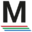
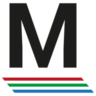
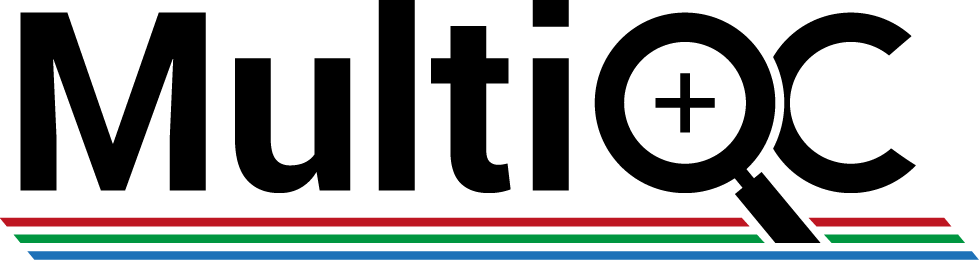
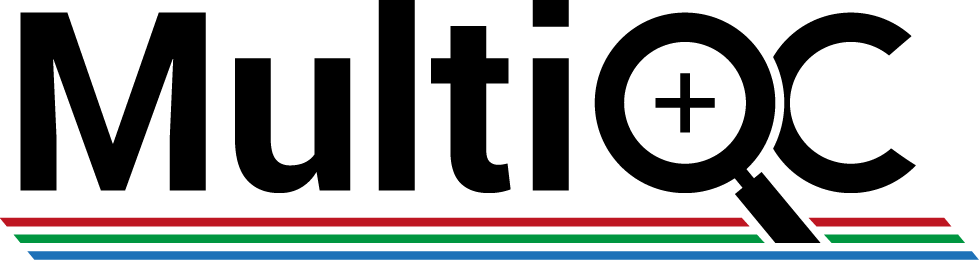
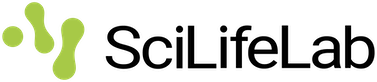

In [44]:
from IPython.display import HTML
HTML(filename='bow/3d-pipeline/hic-pro-output/multiqc_report.html')

### Familiare with the matrix

In [60]:
%%bash
path_matrix=~/bow/3d-pipeline/2nd-hic-pro-output/basalrep1/hic_results/matrix/basalrep1
echo "root matrixes {raw, iced}:" && ls $path_matrix

echo "binsize | #lines raw matrix | #lines iced matrix"
echo "--------|-------------------|-------------------"
for binsize in 20000 50000 150000 500000 1000000;
do
    raw_matrix_filename="$path_matrix/raw/$binsize/basalrep1_$binsize.matrix"
    iced_matrix_filename="$path_matrix/iced/$binsize/basalrep1_$binsize""_iced.matrix"
    
    num_lines_raw_matrix=`wc -l $raw_matrix_filename | awk '{print $1}'`
    num_lines_iced_matrix=`wc -l $iced_matrix_filename | awk '{print $1}'`
    echo "| $binsize | $num_lines_raw_matrix | $num_lines_iced_matrix |"
done

root matrixes {raw, iced}:
iced
raw
binsize | #lines raw matrix | #lines iced matrix
--------|-------------------|-------------------
| 20000 | 25541120 | 25541120 |
| 50000 | 20577246 | 20577246 |
| 150000 | 14578137 | 14578137 |
| 500000 | 7101224 | 7101224 |
| 1000000 | 2975756 | 2975756 |


### Visualize the matrix

resources:
    - https://github.com/nservant/HiC-Pro/blob/master/doc/COMPATIBILITY.md

In [ ]:
## Plot the genome-wide map at 1Mb resolution
binsize=500000
type_matrix="iced"
HiCPlotter="/home/mila/i/ionelia.buzatu/bow/programs/HiCPlotter.py"
root_path="/home/mila/i/ionelia.buzatu/bow/3d-pipeline/2nd-hic-pro-output/basalrep1/hic_results/matrix/basalrep1"

for binsize in [50000, 150000, 500000, 1000000]:
    matrix_filepath = root_path+"/"+type_matrix+"/"+str(binsize)+"/basalrep1_"+str(binsize)+"_iced.matrix" 
    bed_filepath=root_path+"/raw/"+str(binsize)+"/basalrep1_"+str(binsize)+"_abs.bed" 

    # !python $HiCPlotter -f $matrix_filepath -o $type_matrix$binsize -r $binsize -tri 1 -bed $bed_filepath -n "basalrep1" -wg 1 -chr chr6 
    !python $HiCPlotter -f $matrix_filepath -o $root_path"/"$type_matrix"_"$binsize -r $binsize -tri 1 -bed $bed_filepath -n "basalrep1" -chr chr6 

In [85]:
!%HiCPlotter --help

/bin/bash: line 0: fg: no job control


In [ ]:
looking at the matrix does not look like in the paper

In [ ]:
to juicer!

~/bow/programs/HicProinstalldir/HiC-Pro_3.1.0/bin/utils/hicpro2juicebox.sh -i ~/bow/3d-pipeline/hic-pro-output/hic_results/data/basalrep1/basalrep1.allValidPairs -g ~/bow/mm9.chrom.sizes -j ~/juicer_tools_1.22.01.jar -r ~/bow/mm9_hindiii.bed 